In [43]:
import statsmodels
import sklearn 
import pandas as pd
import numpy as np
import scipy as sp
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
import alphien

Hello Mw4315, welcome to Alphien!

Importing your Alphien sub-packages...

import alphien.data
import alphien.portfolio
import alphien.tutorial

Importing your Qlib functions...                                   from team:

No functions in Qlib teams: mw4315

Alphien environment imported. Let's do some research now!


## Data in alphien

Data range from 2007 to 2016 only  
Data source: Bloomberg  
Data for US,UK,HK,DE Equities, Futures, Options and different Indices. No ETF data

In [267]:
 alphien.data.getHistoryData("MSFT.US Equity" , field="ohlcv").tail()

,open_price,high_price,low_price,close_price,volume
date,,,,,
2016-12-23,63.450001,63.540001,62.799999,63.240002,12403819.0
2016-12-27,63.209999,64.070000,63.209999,63.279999,11763173.0
2016-12-28,63.400002,63.400002,62.830002,62.990002,14653348.0
2016-12-29,62.860001,63.200001,62.730000,62.900002,10250582.0
2016-12-30,62.959999,62.990002,62.029999,62.139999,25579908.0


In [268]:
 # Gold futures front month
alphien.data.getHistoryData("GC1 Comdty" , field=['open_interest','volume','open_price','close_price','high_price','low_price']).head()

,open_interest,volume,open_price,close_price,high_price,low_price
date,,,,,,
2007-01-02,188226.0,30976.0,639.200012,638.000000,643.500000,638.500000
2007-01-03,191351.0,162806.0,643.000000,629.799988,647.299988,627.000000
2007-01-04,185850.0,98797.0,629.299988,626.200012,632.799988,622.400024
2007-01-05,179246.0,190384.0,623.599976,606.900024,627.900024,603.000000
2007-01-08,176228.0,89836.0,609.299988,609.400024,612.400024,605.000000


In [4]:
 alphien.data.searchData("lloyd")

6 tickers found for keyword(s): lloyd

You can get ticker time series data with: alphien.data.getHistoryData(ticker=ticker)



,ticker,name,description,sector,region
0,BTE.US Equity,Baytex Energy Corp,"Baytex Energy Corp., an oil and gas company, a...",Energy,USA
1,LLOY.LSE Equity,Lloyds Banking Group plc,Lloyds Banking Group plc provides range of ban...,Financials,UK
2,LYG.US Equity,Lloyds Banking Group plc,Lloyds Banking Group plc provides range of ban...,Financials,USA
3,PRA.US Equity,ProAssurance Corporation,"ProAssurance Corporation, through its subsidia...",Financials,USA
4,QBE.AU Equity,QBE Insurance Group Limited,QBE Insurance Group Limited underwrites genera...,Financials,Australia
5,XL.US Equity,XL Group Ltd,"XL Group Ltd, through its subsidiaries, operat...",Financials,USA


In [5]:
 alphien.data.searchData("aviva")

1 tickers found for keyword(s): aviva

You can get ticker time series data with: alphien.data.getHistoryData(ticker=ticker)



,ticker,name,description,sector,region
0,AV.LSE Equity,Aviva plc,Aviva plc provides various insurance and savin...,Financials,UK


In [6]:
alphien.data.getHistoryData("ESU15C 2100 Index", field=['open_interest','volume','open_price','close_price','high_price','low_price']).head()

,open_interest,volume,open_price,close_price,high_price,low_price
date,,,,,,
2015-07-01,NaN,NaN,NaN,NaN,41.25,36.00
2015-07-02,NaN,NaN,NaN,NaN,40.50,36.50
2015-07-06,NaN,NaN,NaN,NaN,39.25,29.25
2015-07-07,NaN,NaN,NaN,NaN,41.00,27.25
2015-07-08,NaN,NaN,NaN,NaN,35.50,27.50


In [305]:
## dividend history of MSFT
alphien.data.getHistoryData("MSFT.US Equity", field=["dividends",'bb live']).dropna().tail()

,dividends,bb_live
date,,
2015-11-17,0.36,77837.921875
2016-02-16,0.36,75604.320312
2016-05-17,0.36,75278.757812
2016-08-16,0.36,86143.578125
2016-11-15,0.39,88873.062500


In [312]:
## close_prices is not dividend adjusted but bb_live is adjusted close price 
msft = alphien.data.getHistoryData("MSFT.US Equity", field=['close_price','bb live']).pct_change().dropna()

In [314]:
diff = msft['close_price'] - msft['bb_live']

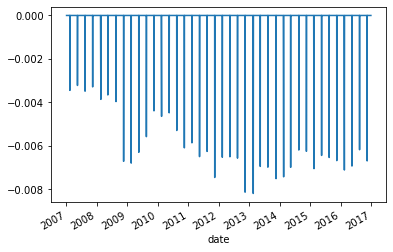

In [317]:
diff.plot()

Work with log returns. Do not work with the raw price data series as it is not stationary. 

In [89]:
gold = alphien.data.getHistoryData("GC1 Comdty" , field=['open_interest','volume','open_price','close_price','high_price','low_price'])

In [90]:
log_gold = (np.log(gold) - np.log(gold.shift(1))).dropna()

In [92]:
for lag in range(1,11):
    for f in log_gold.columns:
        log_gold[f+'_{}'.format(lag)] = log_gold[f].shift(lag)
log_gold.dropna(inplace=True)

Split into train and test data 

In [93]:
from sklearn.model_selection import train_test_split

In [95]:
features = ['close_price_{}'.format(i) for i in range(1,11)]
target = ['close_price']

In [96]:
## Cannot shuffle ts data
X_train, X_test, y_train, y_test = train_test_split(log_gold[features],log_gold[target],test_size=0.2,shuffle=False)

Auto-regressive model: does not work well 

In [97]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [98]:
# y_train.index = pd.DatetimeIndex(y_train.index).to_period('B')
mod = AutoReg(y_train, 50, old_names=False)
res = mod.fit()

/mnt/public/IT/Libs/Python/external/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [99]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:            close_price   No. Observations:                 1971
Model:                    AutoReg(50)   Log Likelihood                5646.979
Method:               Conditional MLE   S.D. of innovations              0.013
Date:                Tue, 27 Oct 2020   AIC                             -8.663
Time:                        15:27:25   BIC                             -8.512
Sample:                            50   HQIC                            -8.608
                                 1971                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      1.295      0.195      -0.000       0.001
close_price.L1      0.0108      0.023      0.471      0.637      -0.034       0.055
close_price.L2     -0.0140      

In [100]:
n_steps = 50
out_sample = res.forecast(steps=n_steps)
out_sample.index = y_test.index[:n_steps]

/mnt/public/IT/Libs/Python/external/statsmodels/tsa/base/tsa_model.py:379: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



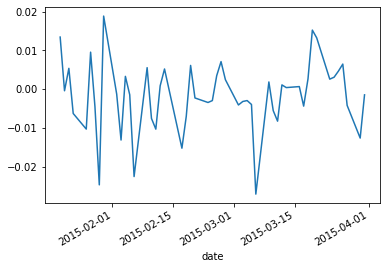

In [101]:
y_test['close_price'][:n_steps].plot()

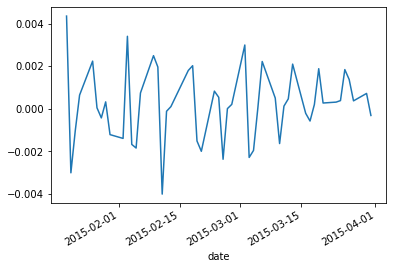

In [102]:
# The data is at a different scale 
out_sample.plot()

In [103]:
np.corrcoef(y_test['close_price'][:n_steps],out_sample)

array([[ 1.        , -0.09144996],
       [-0.09144996,  1.        ]])

Auto-regressive models will produce forecasts that oscialliate around zero for log price series.

LSTM model with keras

In [104]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=20,
    sampling_rate=1,
    batch_size=128,
)

In [105]:
dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=20,
    sampling_rate=1,
    batch_size=1,
)

In [106]:
for batch in dataset_train.take(1):
    inputs, targets = batch

In [107]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(5)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 10)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 326
Trainable params: 326
Non-trainable params: 0
_________________________________________________________________


In [109]:
history = model.fit(
    dataset_train,
    epochs=50,
)

Epoch 1/50
16/16 [==============================] - 1s 31ms/step - loss: 1.5669e-04
Epoch 2/50
16/16 [==============================] - 0s 28ms/step - loss: 1.5323e-04
Epoch 3/50
16/16 [==============================] - 0s 30ms/step - loss: 1.5092e-04
Epoch 4/50
16/16 [==============================] - 0s 29ms/step - loss: 1.4868e-04
Epoch 5/50
16/16 [==============================] - 0s 31ms/step - loss: 1.4557e-04
Epoch 6/50
16/16 [==============================] - 0s 28ms/step - loss: 1.3856e-04
Epoch 7/50
16/16 [==============================] - 0s 28ms/step - loss: 1.4479e-04
Epoch 8/50
16/16 [==============================] - 0s 31ms/step - loss: 1.5136e-04
Epoch 9/50
16/16 [==============================] - 0s 28ms/step - loss: 1.3605e-04
Epoch 10/50
16/16 [==============================] - 0s 28ms/step - loss: 1.3131e-04
Epoch 11/50
16/16 [==============================] - 0s 28ms/step - loss: 1.2685e-04
Epoch 12/50
16/16 [==============================] - 0s 27ms/step - loss: 

In [110]:
import matplotlib.pyplot as plt

In [111]:
actual_values = list()
model_predicts = list()

for x, y in dataset_val.take(30):
    model_predicts.append(model.predict(x)[0][0])
    actual_values.append(y[0][0].numpy())

In [112]:
pd.DataFrame({'actuals':actual_values,'prediction':model_predicts})

,actuals,prediction
0,0.013457,0.007669
1,-0.000386,0.003035
2,0.005396,-0.000212
3,-0.006247,-0.000780
4,-0.010264,-0.005871
5,0.009568,-0.003295
6,-0.004500,-0.001792
7,-0.024642,-0.003815
8,0.018871,-0.003541
9,-0.001252,0.004194


In [113]:
np.corrcoef(actual_values,model_predicts)

array([[1.        , 0.43152399],
       [0.43152399, 1.        ]])

Predicts from LSTM has a positive correlation with the actual values. It suggests LSTM improves by predictions. 

### Conclusion
Simple TS models does not work with equity prices. This applies to ARIMA and similar models. 
Work to do: GARCH model on volatility (not implemented in statsmodels so not shown here) 

LSTM can improve prediction as it overcomes the limitations of AR models. 
Work to do: Explore different nerual network models. Dropout and batch normalisation in particular. Training time for more complicated models can be CPU and time consuming and therefore not done here. 


### What is the shape of the market, PCA on market returns 

In [61]:
SPY_tickers = alphien.data.getTickersSP500()['ticker']
dtf = alphien.data.DataFeatures(list(SPY_tickers), fields='close_price', startDate='2012-01-03', endDate='2016-03-30') 
# load data 
dtf.load()

Ticker(s) CB.US Equity, CBE.US Equity, COV.US Equity, GGP.US Equity, JCI.US Equity, NE.US Equity, RIG.US Equity, TEL.US Equity, TT.US Equity, VAL.US Equity was/were duplicated. These duplicates will be dropped.
Values for CBSS.US Equity, APCC.US Equity, FTV.US Equity, MI.US Equity, UVN.US Equity, PTV.US Equity, RX.US Equity, PGL.US Equity, EOP.US Equity, TRB.US Equity, SLR.US Equity, BNI.US Equity, BOL.US Equity, MFE.US Equity, AYE.US Equity, LEH.US Equity, BDK.US Equity, TXU.US Equity, BJS.US Equity, NOVL.US Equity, JAVA.US Equity, GENZ.US Equity, MEL.US Equity, WWY.US Equity, BRL.US Equity, KSE.US Equity, MEDI.US Equity, AW.US Equity, TEK.US Equity, CEPH.US Equity, BMET.US Equity, ACS.US Equity, SGP.US Equity, SBL.US Equity, ROH.US Equity, ABK.US Equity, DJ.US Equity, MER.US Equity, UA.US Equity, SOV.US Equity, MEE.US Equity, PBG.US Equity, XTO.US Equity, CTX.US Equity, HPC.US Equity, NCC.US Equity, KG.US Equity, WYE.US Equity, CMX.US Equity, CFC.US Equity, ASN.US Equity at requested

In [62]:
market_prices = dtf.first(1000).dropna(axis=1)

In [63]:
market_prices_log = (np.log(market_prices) - np.log(market_prices).shift(1)).dropna()

In [64]:
market_prices_log

,A.US Equity,AA.US Equity,AAP.US Equity,AAPL.US Equity,ABC.US Equity,ABT.US Equity,ACAS.US Equity,ACN.US Equity,ADBE.US Equity,ADI.US Equity,...,XL.US Equity,XLNX.US Equity,XOM.US Equity,XRAY.US Equity,XRX.US Equity,XYL.US Equity,YHOO.US Equity,YUM.US Equity,ZBH.US Equity,ZION.US Equity
2012-01-04,-0.007981,0.023556,0.023174,0.005360,0.003409,-0.003886,0.030473,-0.000378,-0.010202,-0.001389,...,-0.023059,-0.010692,0.000233,-0.000283,-0.006116,0.032482,-0.031501,0.006806,-0.013626,0.022122
2012-01-05,0.022135,-0.009569,0.006343,0.011041,0.007563,-0.002304,-0.016507,-0.019266,0.007047,0.004437,...,0.004049,0.008841,-0.003027,0.000848,-0.006154,-0.014350,-0.008912,0.007602,0.011770,0.027620
2012-01-06,0.010753,-0.021599,0.004626,0.010400,0.002595,-0.009089,0.002770,-0.001735,0.008392,-0.006663,...,0.006544,-0.006507,-0.007491,-0.005950,0.000000,-0.016940,-0.008024,0.007210,0.002597,0.001134
2012-01-09,0.025866,0.029050,-0.000280,-0.001587,-0.000518,-0.000179,-0.003464,-0.001738,-0.006638,0.019311,...,-0.007049,0.021526,0.004454,-0.004843,-0.001235,0.003965,-0.003551,-0.003850,0.007383,0.013514
2012-01-10,0.018586,0.001060,0.000839,0.003574,0.011343,0.004645,0.011728,0.017055,0.023212,0.004362,...,0.024951,0.001824,0.002570,0.014177,0.002469,0.012193,0.003229,0.006186,0.020747,0.016089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-16,0.015078,0.013072,0.029340,0.007663,-0.000984,0.010039,0.003570,0.021873,0.016247,0.017181,...,0.004693,0.000521,-0.003531,0.008472,0.024644,0.020497,0.022453,0.012727,0.008572,0.010691
2015-12-17,-0.015814,-0.009788,-0.049390,-0.021424,0.007356,-0.017304,0.012044,-0.054832,-0.014334,-0.024815,...,-0.001562,-0.018303,-0.015149,-0.003148,-0.007820,-0.027058,-0.016416,-0.018390,-0.012041,-0.016080
2015-12-18,-0.016815,0.008705,-0.023131,-0.027442,-0.004505,-0.035076,-0.023153,-0.012964,-0.031160,-0.017073,...,-0.019199,-0.012391,-0.008761,-0.010510,-0.003933,-0.017151,-0.008462,-0.004999,-0.017529,-0.038558
2015-12-21,0.018041,0.009704,0.000535,0.012186,0.009865,0.007750,0.012534,0.010346,0.003389,0.011892,...,0.006353,0.016628,-0.000258,0.007019,0.014670,0.008336,0.000455,0.021483,0.012752,0.002244


In [65]:
from sklearn.decomposition import PCA

In [66]:
# 20% of the variance in the data can be explained by the first component (overall market)
pca = PCA(n_components=5)
pca.fit(market_prices_log)
pca.explained_variance_ratio_

array([0.19629517, 0.03108883, 0.02399934, 0.02331611, 0.0229648 ],
      dtype=float32)

In [67]:
# This is the 2D representation of a stock in the score space
pca.components_

array([[-0.0501411 , -0.05388444, -0.03610355, ..., -0.03549845,
        -0.03431157, -0.05048312],
       [ 0.01349967, -0.04111544,  0.03485853, ...,  0.02644556,
         0.01903135, -0.00087312],
       [ 0.00678121, -0.01667945, -0.00494642, ...,  0.00061759,
         0.00111378,  0.0017938 ],
       [ 0.00530252,  0.01424648, -0.00672421, ..., -0.01138197,
        -0.00969306, -0.00221613],
       [ 0.00096083, -0.00250015,  0.00800751, ...,  0.00728353,
         0.00418575,  0.00720358]], dtype=float32)

In [87]:
pd.Series(pca.components_[0,:]).describe()

count    552.000000
mean      -0.040363
std        0.013519
min       -0.091390
25%       -0.048582
50%       -0.039255
75%       -0.030957
max       -0.012799
dtype: float64

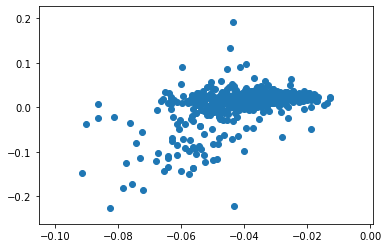

In [70]:
plt.scatter(x=pca.components_[0,:], y=pca.components_[1,:])

Shared market trends. From third components 

In [71]:
market_trend = pd.DataFrame(pca.fit_transform(market_prices_log))
market_trend.index = market_prices_log.index

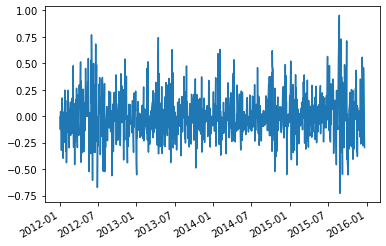

In [72]:
market_trend[0].plot()

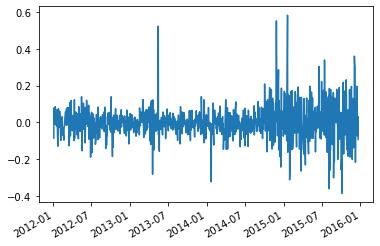

In [73]:
market_trend[1].plot()

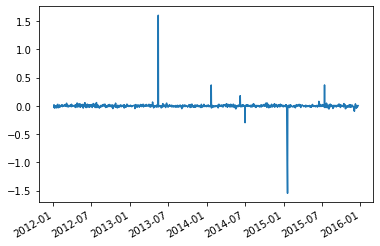

In [74]:
market_trend[2].plot()

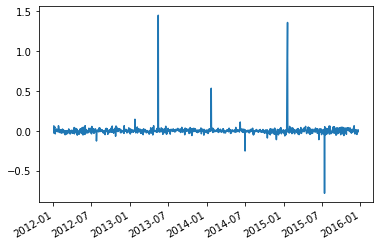

In [86]:
market_trend[3].plot()

Why use PCA rather than beta with respect to SP 500?  

Computing linear regression for a large number of securities can be slow. In PCA we can do all the price series at once.
SP 500 has a lag in changing its composition. By choosing the top 500 securities that meets our own criteria, we can create a dynamic benchmark of market return.



In [68]:
 ?alphien.data.getHistoryData

Signature:
alphien.data.getHistoryData(
    ticker,
    field='close_price',
    start=None,
    end=None,
    zoom=None,
    lastN=None,
    period=None,
)
Docstring:
Function to retrieve time series from ticker names and their fields

   Function to retrieve time series from ticker names and their fields.
   To know more about data retrieval, please consult the [https://dashboard.alphien.com/knowledge-base/Cheatsheet_For_Data_Access data access guide].

Args:
    ticker (str/list): Ticker name(s), a string or a list. The ticker name has to include the extension. E.g. "VIX Index". 
                       Check the data access guide to see the format of a correct ticker.
    field (str/list): Correct field name(s). e.g: field="OHLCV", field=["close_price", "volume"]. Check the data access guide to see available fields.
    start (str): A date in YYYY-MM-DD format defining series start (defaults to oldest data available). E.g. start="2018-05-27"
    end (str): A date in YYYY-MM-DD forma

In [61]:
 alphien.data.getTickersSP500Data()

,ticker,description
tablerownames,,
1,SPX Index,S&P 500 Index
2,SPTR Index,S&P 500 Total Return Index
3,CCMP Index,Nasdaq Composite
4,INDU Index,Dow Jones Industrial Average
5,SX5E Index,Eurostoxx 50
6,NKY Index,Nikkei 225
7,VIX Index,1m Implied Volatity index on S&P 500
8,USGG2YR Index,US 2y Government bond benchmark yield
9,USGG10YR Index,US 10y Government bond benchmark yield


In [85]:
alphien.data.searchData('SPY')

9 tickers found for keyword(s): SPY

You can get ticker time series data with: alphien.data.getHistoryData(ticker=ticker)



,ticker,name,description,sector,region
0,CHTR.US Equity,"Charter Communications, Inc","Charter Communications, Inc., through its subs...",Communication Services,USA
1,FNJN.US Equity,"Finjan Holdings, Inc","Finjan Holdings, Inc., a cybersecurity company...",Information Technology,USA
2,JHX.AU Equity,James Hardie Industries plc,"James Hardie Industries plc, together with its...",Materials,Australia
3,JHX.US Equity,James Hardie Industries plc,"James Hardie Industries plc, together with its...",Materials,USA
4,LBRDA.US Equity,Liberty Broadband Corporation,"Liberty Broadband Corporation, a cable operato...",Communication Services,USA
5,LBRDK.US Equity,Liberty Broadband Corporation,"Liberty Broadband Corporation, a cable operato...",Communication Services,USA
6,PII.US Equity,Polaris Inc,"Polaris Inc. designs, engineers, manufactures,...",Consumer Discretionary,USA
7,SCHL.US Equity,Scholastic Corporation,Scholastic Corporation publishes and distribut...,Communication Services,USA
8,SPRT.US Equity,"Support.com, Inc","Support.com, Inc. provides customer support se...",Information Technology,USA
